## Gaussian Mixture Model (GMM)

### - import libraries

In [1]:
import numpy as np
import pandas as pd
# import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import multivariate_normal

In [2]:
# Set random seem for reproducibility
manualSeed = 2019
np.random.seed(manualSeed)

### - import data

In [3]:
data = pd.read_csv('datasets/train/pathbased.csv', header=None)
data = data.values

### - define functions

In [4]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

### - algos

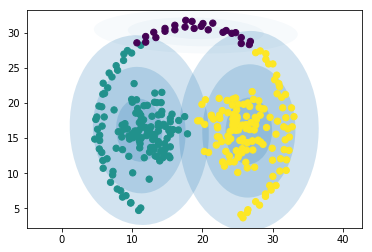

In [5]:
from sklearn.mixture import GaussianMixture as GMM
cluster_num = 3
gmm_model = GMM(n_components=cluster_num, random_state=2019).fit(data)
plot_gmm(gmm_model, data)

### - multi-variables

In [6]:
x = np.arange(round(min(data[:, 0])) - 10, round(max(data[:, 0])) + 10, 0.1)
y = np.arange(round(min(data[:, 1])) - 10, round(max(data[:, 1])) + 10, 0.1)
xx, yy = np.meshgrid(x, y, sparse=True)

a = xx + yy - yy
b = xx + yy - xx
mem = np.concatenate([
    a.reshape([a.shape[0], a.shape[1], 1]),
    b.reshape([a.shape[0], a.shape[1], 1])
],
                     axis=2)

In [7]:
pred = np.zeros([mem.shape[0], mem.shape[1]])
scaler = np.zeros(cluster_num)
for i in range(mem.shape[0]):
    for j in range(mem.shape[1]):
        for idx in range(cluster_num):
            scaler[idx] = np.maximum(
                scaler[idx],
                multivariate_normal.pdf(mem[i, j, :].reshape([1, -1]),
                                        mean=gmm_model.means_[idx, :],
                                        cov=gmm_model.covariances_[idx, :] *
                                        10))

In [8]:
for i in range(mem.shape[0]):
    for j in range(mem.shape[1]):
        for idx in range(cluster_num):
            pred[i, j] = np.maximum(
                pred[i, j],
                multivariate_normal.pdf(
                    mem[i, j, :].reshape([1, -1]),
                    mean=gmm_model.means_[idx, :],
                    cov=gmm_model.covariances_[idx, :] * 10) / scaler[idx])

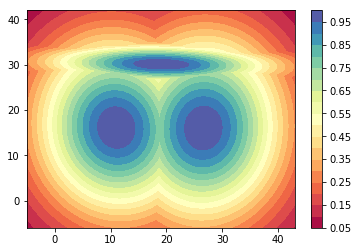

In [9]:
h = plt.contourf(x, y, pred / np.max(pred), 20, cmap='Spectral')
# plt.plot(data[:, 0], data[:, 1], '.b', label='Real')
plt.colorbar()

plt.xlim(round(min(data[:, 0])) - 10, round(max(data[:, 0])) + 10)
plt.ylim(round(min(data[:, 1])) - 10, round(max(data[:, 1])) + 10)
plt.show()

### - evaluation

In [10]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [11]:
test = pd.read_csv('datasets/test/pathbased_test.csv', header=None)
test = test.values
label = test[:, 2]
label = label.reshape([-1, 1])
test = test[:, :2]

In [78]:
test_score = np.zeros([len(test)])
for iter in range(len(test)):
    for idx in range(cluster_num):
        test_score[iter] = np.maximum(
            test_score[iter],
            multivariate_normal.pdf(test[iter, :],
                                    mean=gmm_model.means_[idx, :],
                                    cov=gmm_model.covariances_[idx, :] * 10) /
            scaler[idx])

In [79]:
alpha = 0.7 #* np.max(test_score)
for i in range(test_score.shape[0]):
    if test_score[i] > alpha:
        test_score[i] = 0
    else:
        test_score[i] = 1

precision = average_precision_score(label, test_score)
recall = recall_score(label, test_score)
F1 = 2 * (precision * recall) / (precision + recall)
print('Precision score: {0:0.2f}'.format(precision))
print('Recall score: {0:0.2f}'.format(recall))
print('F1 score: {0:0.2f}'.format(F1))

Precision score: 0.82
Recall score: 0.70
F1 score: 0.76


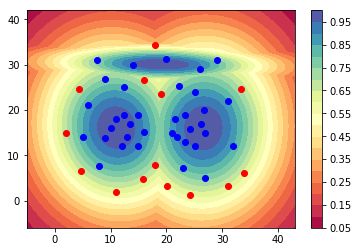

In [80]:
h = plt.contourf(x, y, pred / np.max(pred), 20, cmap='Spectral')
plt.colorbar()

plt.xlim(round(min(data[:, 0])) - 10, round(max(data[:, 0])) + 10)
plt.ylim(round(min(data[:, 1])) - 10, round(max(data[:, 1])) + 10)

for i in range(test_score.shape[0]):
    if test_score[i] > alpha:
        plt.plot(test[i, 0],
                 test[i, 1],
                 'or',
                 label='Test')
    else:
        plt.plot(test[i, 0],
                 test[i, 1],
                 'ob',
                 label='Test')

plt.show()